In [55]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [56]:
import sqlite3
import numpy as np
import pandas as pd
import eofs.standard as eofs
import pylab as plt
import scipy.stats as stats
import scipy.signal as signal
from mpl_toolkits.basemap import Basemap
import tools

In [57]:
plt.style.use("coolbeans")

In [58]:
DB_PATH = "./data/riversdb.sqlite"
TWENTY_PATH = "./data/20th_rean_V2.npz"
ERSST_PATH = "./data/ersst.npz"
LONGCALYEAR_LOW = 1949
LONGCALYEAR_HIGH = 2000
WESTOFLON = -104
EASTOFLON = -125
SPECIAL_GAGES = ["Colorado River at Lees Ferry, AZ",
                 "Columbia River at Dalles, OR",
                 # Need Klamath River at Keno, OR. In the meantime:
                 "Missouri River at Toston, MT",
#                  "Trinity River at Lewiston, CA",
                 # Need Rio Grande near Del Norte, CO. I have no sub for this.
                 "Sacramento Four Rivers Index",
                 "Salt-Verde-Tonto waterways, AZ",
#                  "Jackson Lake at Dam on Snake River near Moran, WY",
                 "South Platte River at South Platte, CO"]
                 

In [59]:
# Grab data from SQLITE3 DB.
conn = sqlite3.connect(DB_PATH)
sql_query = "SELECT gagename, year, value FROM Gage WHERE year <= 2000 AND year >= 1949 AND gagename IN ({seq}) GROUP BY gagename, year ORDER BY gagename, year ASC".format(seq = ",".join(["?"] * len(SPECIAL_GAGES)))
raw = pd.read_sql(sql_query, conn, params = SPECIAL_GAGES, index_col = ["year", "gagename"])
conn.close()

In [60]:
# Get corresponding latitude and longitude.
conn = sqlite3.connect(DB_PATH)
sql_query = "SELECT gagename, lat, lon FROM GageMeta WHERE gagename IN ({seq}) ORDER BY gagename ASC".format(seq = ",".join(["?"] * len(SPECIAL_GAGES)))
latlon = pd.read_sql(sql_query, conn, params = SPECIAL_GAGES)
conn.close()

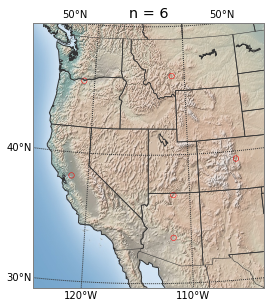

In [61]:
# Plot simple sample map.
out = tools.plot_gagesmap(latlon["lat"].as_matrix(), latlon["lon"].as_matrix())


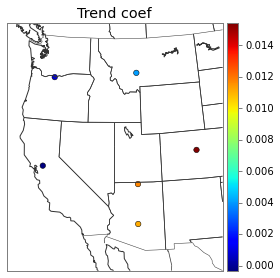

In [62]:
# Parse and shape the data we grabbed. Standardize it. Grad trend coefficients.
parsed = raw.groupby(level = "gagename")["value"].transform(tools.spigamma)

trend_coefs = parsed.groupby(level = "gagename").apply(tools.trender)
# Detrending. Let's see what happens.
# parsed = parsed.groupby(level = "stationid").transform(signal.detrend)
parsed = parsed.unstack()

# Map trend coefs.
yr = np.arange(LONGCALYEAR_LOW, LONGCALYEAR_HIGH + 1)
out = tools.plot_trendmap(trend_coefs, latlon["lat"].as_matrix(), latlon["lon"].as_matrix())

In [63]:
# DEBUG
parsed

gagename,"Colorado River at Lees Ferry, AZ","Columbia River at Dalles, OR","Missouri River at Toston, MT",Sacramento Four Rivers Index,"Salt-Verde-Tonto waterways, AZ","South Platte River at South Platte, CO"
year,,,,,,
1949,0.578820,-0.354415,-0.128706,-0.799626,0.390583,1.529107
1950,-0.153214,0.589001,-0.568843,-0.423813,-0.959709,-1.025311
1951,-0.354131,1.053824,0.063715,0.608101,-0.892289,-0.394381
1952,1.378481,0.323244,0.651492,1.158190,1.083002,0.169862
1953,-0.682165,-0.529462,-0.233794,0.295196,-0.887102,-0.590740
1954,-1.512132,-0.112859,-1.049469,-0.023612,-0.509192,-1.907708
1955,-1.073609,-1.151350,-1.078289,-0.965381,-0.882937,-1.169655
1956,-0.602910,1.380467,-0.022277,1.273693,-1.221661,-0.957216
1957,1.246963,-0.317613,-0.446512,-0.360197,-0.298707,1.424764


In [64]:
# Interesting iterations are:
# 1) standardized, correlation or covariance (`center = True` in this case).
# 2) Non-standardized correlation.

solver = eofs.Eof(parsed.as_matrix(), center = False)
eof = solver.eofsAsCovariance(neofs = 4)
pc = solver.pcs(npcs = 4, pcscaling = 1)
frac_var = solver.varianceFraction(4)

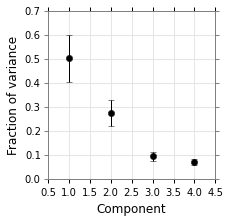

In [65]:
# Basic North Test plot

out = tools.plot_northtest(solver, nmodes = 4)

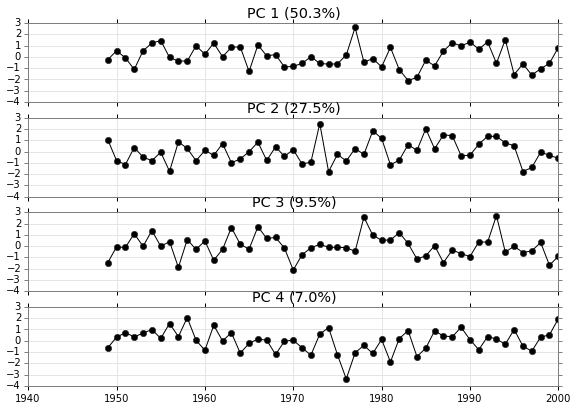

In [66]:
# Plot 6 leading PCs.

out = tools.plot_pc(solver, yr = np.arange(LONGCALYEAR_LOW, LONGCALYEAR_HIGH + 1), nmodes = 4)

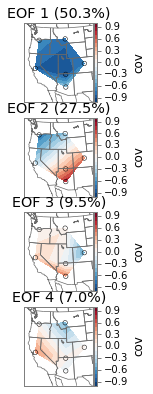

In [67]:
# Plot 6 leading EOFs.

out = tools.plot_eof(solver, lat = latlon["lat"].as_matrix(), lon = latlon["lon"].as_matrix(), nmodes = 4)

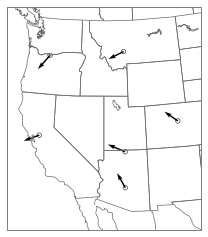

In [68]:
rcoef1 = parsed.stack().groupby(level = "gagename").aggregate(lambda x: stats.linregress(pc[:, 0], x)[0])
rcoef2 = parsed.stack().groupby(level = "gagename").aggregate(lambda x: stats.linregress(pc[:, 1], x)[0])
# print(rcoef1)
# print(rcoef2)
plt.figure(figsize = (5, 4))
m = Basemap(width = 2000000, height = 2300000, 
            resolution = 'l', projection = 'stere', 
            lat_ts = 40.0, 
            lat_0 = 40.0, lon_0 = -114.0)
x, y = m(latlon["lon"].as_matrix(), latlon["lat"].as_matrix())
m.drawcoastlines(linewidth = 0.7, color = "#696969")
m.drawstates(linewidth = 0.7, color = "#696969")
m.drawcountries(linewidth = 0.7, color = "#696969")
m.quiver(x, y, rcoef1, rcoef2, scale = 10)
m.scatter(x, y, facecolors = "none", edgecolor = "k")
plt.show()

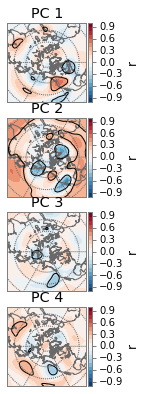

In [69]:
# Plot NDJ 500 mb point correlations.

twenty = np.load(TWENTY_PATH)
msk_time = (twenty["time"] >= LONGCALYEAR_LOW) & (twenty["time"] <= LONGCALYEAR_HIGH)
hgts = twenty["data"][0, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
out = tools.plot_pearson(solver, hgts, lat = twenty["lat"], lon = twenty["lon"], nmodes = 4)

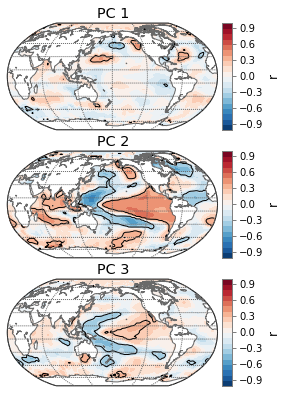

In [70]:
# Correlate PCs with OI SST data (NDJ mean) detrended anomalies.

ersst = np.load(ERSST_PATH)
msk_time = (ersst["time"] >= LONGCALYEAR_LOW) & (ersst["time"] <= LONGCALYEAR_HIGH)
sst = ersst["data"][0, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
out = tools.plot_pearson(solver, sst, lat = ersst["lat"], lon = ersst["lon"], nmodes = 3, msk = ersst["landmask"], world_map = True)

# Below is a crazy experiment with aggregating gage series

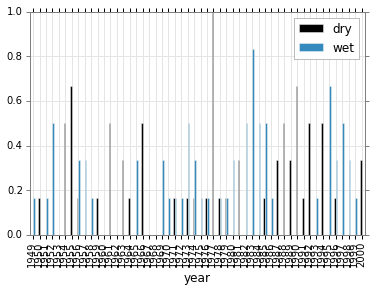

In [71]:
# less_ts = parsed.groupby(level = "year").aggregate(lambda x: np.sum(x < -1.3)/len(x))
abs_thresh = 1
test = pd.DataFrame()
test["dry"] = parsed.unstack().groupby(level = "year").aggregate(lambda x: np.sum(x < -abs_thresh)/len(x))
test["wet"] = parsed.unstack().groupby(level = "year").aggregate(lambda x: np.sum(x > abs_thresh)/len(x))
test.plot(kind = "bar", stacked = False)
plt.show()

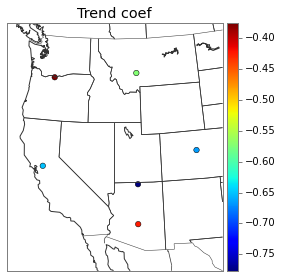

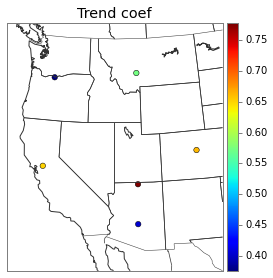

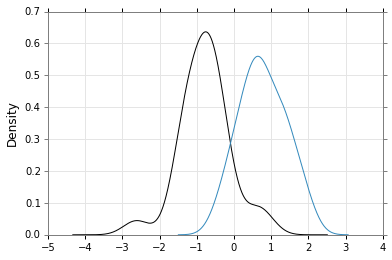

In [72]:
wy_range = np.arange(LONGCALYEAR_LOW, LONGCALYEAR_HIGH + 1)
quarts = pd.qcut(pc[:, 0], [0, 0.5, 1], labels = ["low", "high"])
# quarts = pd.qcut(pc[:, 0], [0, 0.3, 0.6, 1], labels = ["low", "mid", "high"])
# parsed.unstack()
# print(wy_range[(quarts == "high")])
## parsed.groupby(level = "stationid").aggregate
high_mean = parsed.unstack().iloc[parsed.unstack().index.isin(wy_range[(quarts == "high")], level = 1)].groupby(level = "gagename").aggregate(np.mean)
low_mean = parsed.unstack().iloc[parsed.unstack().index.isin(wy_range[(quarts == "low")], level = 1)].groupby(level = "gagename").aggregate(np.mean)
tools.plot_trendmap(high_mean, latlon["lat"].as_matrix(), latlon["lon"].as_matrix())
tools.plot_trendmap(low_mean, latlon["lat"].as_matrix(), latlon["lon"].as_matrix())
plt.show()
parsed.unstack().iloc[parsed.index.isin(wy_range[(quarts == "high")], level = 0)].plot(kind = "kde")
parsed.unstack().iloc[parsed.index.isin(wy_range[(quarts == "low")], level = 0)].plot(kind = "kde")
## plt.legend()

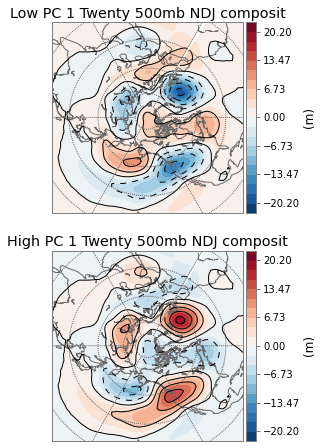

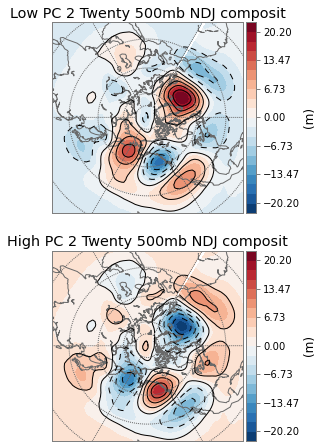

PC1 low+high:
[1949 1951 1952 1957 1958 1965 1969 1970 1971 1973 1974 1975 1978 1979 1980
 1982 1983 1984 1985 1986 1993 1995 1996 1997 1998 1999]
[1950 1953 1954 1955 1956 1959 1960 1961 1962 1963 1964 1966 1967 1968 1972
 1976 1977 1981 1987 1988 1989 1990 1991 1992 1994 2000]
PC2 low+high:
[1950 1951 1953 1954 1955 1956 1959 1961 1963 1964 1967 1969 1971 1972 1974
 1975 1976 1978 1981 1982 1989 1990 1996 1997 1999 2000]
[1949 1952 1957 1958 1960 1962 1965 1966 1968 1970 1973 1977 1979 1980 1983
 1984 1985 1986 1987 1988 1991 1992 1993 1994 1995 1998]


In [73]:
# Composite map of NDJ mean 500 mb height anomalies.
twenty = np.load(TWENTY_PATH)
msk_time = (twenty["time"] >= LONGCALYEAR_LOW) & (twenty["time"] <= LONGCALYEAR_HIGH)
hgts = twenty["data"][0, 1, msk_time]

# First dim is PC, second is 0 -> low, 1 -> high:
composit_anoms = np.zeros((2, 2, hgts.shape[1], hgts.shape[2]))
for i in range(2):
#     quarts = pd.qcut(pc[:, i], [0, 0.25, 0.75, 1], labels = ["low", "mid", "high"])
    quarts = pd.qcut(pc[:, i], [0, 0.5, 1], labels = ["low", "high"])
    composit_anoms[i, 0] = np.mean(hgts[(quarts == "low")], 0) - np.mean(hgts, 0)
    composit_anoms[i, 1] = np.mean(hgts[(quarts == "high")], 0) - np.mean(hgts, 0)

wings = np.max([np.absolute(composit_anoms.min()), np.absolute(composit_anoms.max())])
divs = np.linspace(-wings, wings, 21)
divs2 = np.linspace(-wings, wings, 11)
fig, axes = plt.subplots(figsize = (8, 7.5), nrows = 2, ncols = 1)
for i in range(2):
    m = Basemap(ax = axes.flat[i], projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
    x, y = m(twenty["lon"], twenty["lat"])
    m.drawcoastlines(color = "#696969")
    m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
    m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
    m.contour(x, y, composit_anoms[0, i], divs2, colors = "k")
    pcol = m.contourf(x, y, composit_anoms[0, i], divs,cmap = plt.cm.RdBu_r)
    cb = m.colorbar(pcol)
    cb.set_label("(m)")
    axes.flat[i].set_title(("Low", "High")[i]+" PC 1" + " Twenty 500mb NDJ composit")
plt.show()

fig, axes = plt.subplots(figsize = (8, 7.5), nrows = 2, ncols = 1)
for i in range(2):
    m = Basemap(ax = axes.flat[i], projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
    x, y = m(twenty["lon"], twenty["lat"])
    m.drawcoastlines(color = "#696969")
    m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
    m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
    m.contour(x, y, composit_anoms[1, i], divs2, colors = "k")
    pcol = m.contourf(x, y, composit_anoms[1, i], divs, cmap = plt.cm.RdBu_r)
    cb = m.colorbar(pcol)
    cb.set_label("(m)")
    axes.flat[i].set_title(("Low", "High")[i]+" PC 2" + " Twenty 500mb NDJ composit")
plt.show()

# quarts = pd.qcut(pc[:, 0], [0, 0.25, 0.75, 1], labels = ["low", "mid", "high"])
quarts = pd.qcut(pc[:, 0], [0, 0.5, 1], labels = ["low", "high"])
print("PC1 low+high:")
print(yr[quarts == "low"])
print(yr[quarts == "high"])
# quarts = pd.qcut(pc[:, 1], [0, 0.25, 0.75, 1], labels = ["low", "mid", "high"])
quarts = pd.qcut(pc[:, 1], [0, 0.5, 1], labels = ["low", "high"])
print("PC2 low+high:")
print(yr[quarts == "low"])
print(yr[quarts == "high"])

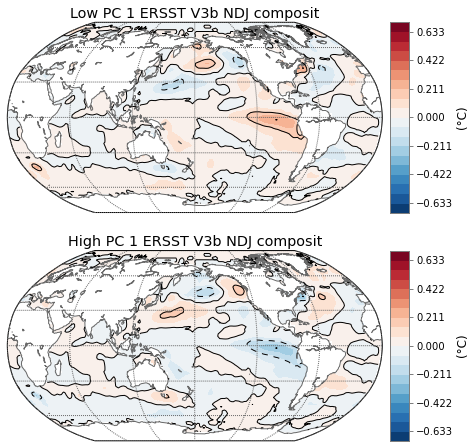

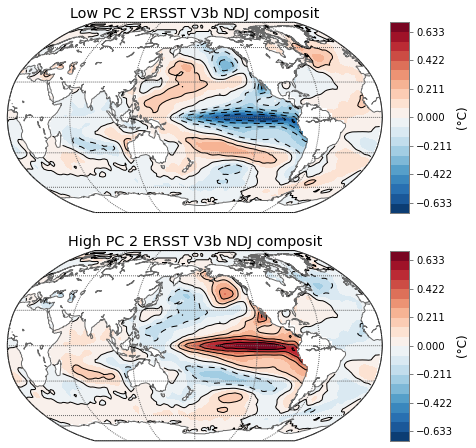

PC1 low+high:
[1949 1951 1952 1957 1958 1965 1969 1970 1971 1973 1974 1975 1978 1979 1980
 1982 1983 1984 1985 1986 1993 1995 1996 1997 1998 1999]
[1950 1953 1954 1955 1956 1959 1960 1961 1962 1963 1964 1966 1967 1968 1972
 1976 1977 1981 1987 1988 1989 1990 1991 1992 1994 2000]
PC2 low+high:
[1950 1951 1953 1954 1955 1956 1959 1961 1963 1964 1967 1969 1971 1972 1974
 1975 1976 1978 1981 1982 1989 1990 1996 1997 1999 2000]
[1949 1952 1957 1958 1960 1962 1965 1966 1968 1970 1973 1977 1979 1980 1983
 1984 1985 1986 1987 1988 1991 1992 1993 1994 1995 1998]


In [74]:
# Composite map of NDJ detrended sea surface temperature anomalies.
ersst = np.load(ERSST_PATH)
msk_time = (ersst["time"] >= LONGCALYEAR_LOW) & (ersst["time"] <= LONGCALYEAR_HIGH)
sst = ersst["data"][0, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")

# First dim is PC, second is 0 -> low, 1 -> high:
composit_anoms = np.zeros((2, 2, sst.shape[1], sst.shape[2]))
for i in range(2):
#     quarts = pd.qcut(pc[:, i], [0, 0.25, 0.75, 1], labels = ["low", "mid", "high"])
    quarts = pd.qcut(pc[:, i], [0, 0.5, 1], labels = ["low", "high"])
    composit_anoms[i, 0] = np.mean(sst[(quarts == "low")], 0) - np.mean(sst, 0)
    composit_anoms[i, 1] = np.mean(sst[(quarts == "high")], 0) - np.mean(sst, 0)

wings = np.max([np.absolute(composit_anoms.min()), np.absolute(composit_anoms.max())])
divs = np.linspace(-wings, wings, 21)
divs2 = np.linspace(-wings, wings, 11)
fig, axes = plt.subplots(figsize = (8, 7.5), nrows = 2, ncols = 1)
for i in range(2):
    c = np.ma.masked_array(composit_anoms[0, i], ersst["landmask"])
    m = Basemap(ax = axes.flat[i], projection = "robin", lon_0 = 180, resolution = "c")
    x, y = m(ersst["lon"], ersst["lat"])
    m.drawcoastlines(color = "#696969")
    m.drawparallels(np.arange(-90.,120.,30.), color = "#696969")
    m.drawmeridians(np.arange(0.,360.,60.), color = "#696969")
    m.contour(x, y, c, divs2, colors = "k")
    pcol = m.contourf(x, y, c, divs, cmap = plt.cm.RdBu_r)
    cb = m.colorbar(pcol)
    cb.set_label("(°C)")
    axes.flat[i].set_title(("Low", "High")[i]+" PC 1" + " ERSST V3b NDJ composit")
plt.show()

fig, axes = plt.subplots(figsize = (8, 7.5), nrows = 2, ncols = 1)
for i in range(2):
    c = np.ma.masked_array(composit_anoms[1, i], ersst["landmask"])
    m = Basemap(ax = axes.flat[i], projection = "robin", lon_0 = 180, resolution = "c")
    x, y = m(ersst["lon"], ersst["lat"])
    m.drawcoastlines(color = "#696969")
    m.drawparallels(np.arange(-90.,120.,30.), color = "#696969")
    m.drawmeridians(np.arange(0.,360.,60.), color = "#696969")
    m.contour(x, y, c, divs2, colors = "k")
    pcol = m.contourf(x, y, c, divs, cmap = plt.cm.RdBu_r)
    cb = m.colorbar(pcol)
    cb.set_label("(°C)")
    axes.flat[i].set_title(("Low", "High")[i]+" PC 2" + " ERSST V3b NDJ composit")
plt.show()

# quarts = pd.qcut(pc[:, 0], [0, 0.25, 0.75, 1], labels = ["low", "mid", "high"])
quarts = pd.qcut(pc[:, 0], [0, 0.5, 1], labels = ["low", "high"])
print("PC1 low+high:")
print(yr[quarts == "low"])
print(yr[quarts == "high"])
# quarts = pd.qcut(pc[:, 1], [0, 0.25, 0.75, 1], labels = ["low", "mid", "high"])
quarts = pd.qcut(pc[:, 1], [0, 0.5, 1], labels = ["low", "high"])
print("PC2 low+high:")
print(yr[quarts == "low"])
print(yr[quarts == "high"])

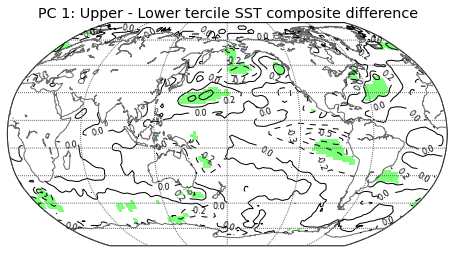

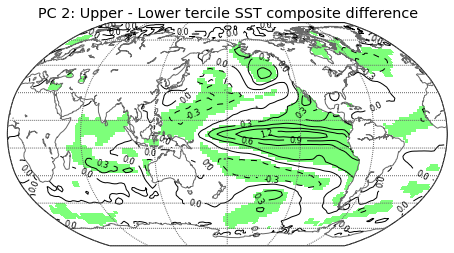

In [75]:
# Welch's t-test comparing upper and lower quartiles.
for i in range(2):
#     quarts = pd.qcut(pc[:, i], [0, 0.33, 0.66, 1], labels = ["low", "mid", "high"])
    quarts = pd.qcut(pc[:, i], [0, 0.5, 1], labels = ["low", "high"])
    t, p = stats.ttest_ind(sst[(quarts == "high")], sst[(quarts == "low")], equal_var = False)
    d = np.mean(sst[(quarts == "high")], 0) - np.mean(sst[(quarts == "low")], 0)
    d = np.ma.masked_array(d, ersst["landmask"])
    p = np.ma.masked_array(p, ersst["landmask"])
    plt.figure(figsize = (8, 4))
    m = Basemap(projection = "robin", lon_0 = 180, resolution = "c")
    c = np.ma.masked_array(p, ~(p <= 0.1))
    x, y = m(ersst["lon"], ersst["lat"])
    m.drawcoastlines(color = "#696969")
    m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
    m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
    ct = m.contour(x, y, d, colors = "k")
    plt.clabel(ct, fontsize=8, inline=1, fmt = "%1.1f")
    m.contourf(x, y, c, 0)
    plt.title("PC " + str(i + 1) + ": Upper - Lower tercile SST composite difference")
    plt.show()